In [24]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F
import networkx as nx

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import SrcIdModel, LinDAGClassModel
from src.baselines_archs import MyGCNN, GAT, MLP, GraphSAGE, GIN

# Ser random seed
SEED = 10
PATH = 'results/src_id/'
SAVE = False
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

### Default parameters and auxiliary functions

In [25]:
M = 2000

data_p = {
    'n_tries': 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'random',          # 'random' or 'constant'
    'max_src_node': 20,  # 10           # Maximum index of nodes allowed to be sources
    'n_sources': 1,              # Maximum Number of source nodes
    'n_p_y': .05,  
    'n_p_x': 0,                  # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 32,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
    'l_act': None,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-3,         # Learning rate
    'epochs': 100,  # 50,       # Number of training epochs 
    'pat': 25,  # 15,          # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

##########   AUXILIARY FUNCTIONS   ##########   
def get_signals(d_p, GSOs, get_srcs=False):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    signals_t, srcs_t, _ = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p_y'],
                                                d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True,
                                                mask_sources=True)
    labels_t = torch.argmax(torch.abs(srcs_t), axis=1)

    signals = {'train': signals_t[:d_p['M_train']], 'val': signals_t[d_p['M_train']:-d_p['M_test']],
                 'test': signals_t[-d_p['M_test']:]}
    labels = {'train': labels_t[:d_p['M_train']], 'val': labels_t[d_p['M_train']:-d_p['M_test']],
              'test': labels_t[-d_p['M_test']:]}
    
    if get_srcs:
        srcs = {'train': srcs_t[:d_p['M_train']], 'val': srcs_t[d_p['M_train']:-d_p['M_test']],
              'test': srcs_t[-d_p['M_test']:]}
        
        return signals, labels, sel_GSOs, srcs
    
    return signals, labels, sel_GSOs


def run_exp(d_p, d_arc_p, d_mod_p, exps):
    acc = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    for i in range(d_p['n_tries']):
        Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
        signals, labels, sel_GSOs, srcs = get_signals(d_p, GSOs, get_srcs=True)

        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']} if 'arc_p' in exp else d_arc_p
            mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

            if arc_p['arch'] == LinDAGClassModel:
                if 'transp' in arc_p.keys() and arc_p['transp']:
                    dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
                    Psi = np.array([dagu.compute_Dq(dag_T, i, d_p['N']) for i in range(d_p['N'])]).T
                    arc_p['transp'] = False

                Psi_sel = utils.select_GSO(arc_p, Psi.T, None, W, Adj).numpy().T
                lin_model = LinDAGClassModel(W, Psi_sel)
                t_i = time.time()
                # lin_model.fit(signals['train'], labels['train'])
                lin_model.fit(signals['train'], srcs['train'])
                t_e = time.time() - t_i

                acc[i,j] = lin_model.test(signals['test'], labels['test'])
            
            else:
                GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
                K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
                arch = utils.instantiate_arch(arc_p, K)
                model = SrcIdModel(arch, device=device)

                t_i = time.time()
                model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                        patience=mod_p['pat'])
                t_e = time.time() - t_i

                acc[i,j] = model.test(signals['test'], labels['test'], GSO)
            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: acc: {acc[i,j]:.3f} - time: {times[i,j]:.1f}')
    
    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times


def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, exp_desc='default'):
    acc_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))
    
    signals, labels, sel_GSOs = get_signals(d_dat_p, GSOs)
    
    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

        GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
        K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
        arch = utils.instantiate_arch(arc_p, K)
        model = SrcIdModel(arch, device=device)
        
        t_i = time.time()
        model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                  patience=mod_p['pat'])
        t_e = time.time() - t_i
        
        acc_exps[k] = model.test(signals['test'], labels['test'], GSO)
        times_exps[k] = t_e

        print(f'\t-{exp_desc}. {exp["leg"]}: acc: {acc_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return acc_exps, times_exps

## Initial Test - As classification problem

In [3]:
Exps = [
    # My Model
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DCN-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10'},

    # My Model - Transposed
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DCN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10-T'},

    # Linear baselines
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'GSOs'}, 'leg': 'Linear'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'Linear-30'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-10'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'GSOs', 'transp': True}, 'leg': 'Linear-T'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'Linear-30-T'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'Linear-10-T'},

    # GNN Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': True}, 'leg': 'FB-GCNN-2'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A'},
    # {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'transp': True, 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A'},
    # {'arc_p': {'arch': GraphSAGE, 'GSO': 'W-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-W'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A'},
    # {'arc_p': {'arch': GIN, 'GSO': 'W-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-W'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},    
    ]

acc, times = run_exp(data_p, default_arch_p, default_mod_p, Exps)

-0. DCN: acc: 0.025 - time: 37.8
-0. DCN-30: acc: 0.040 - time: 42.6
-0. DCN-10: acc: 0.030 - time: 33.6
-0. DCN-T: acc: 0.990 - time: 32.3
-0. DCN-30-T: acc: 0.985 - time: 27.8
-0. DCN-10-T: acc: 0.820 - time: 40.4
-0. Linear: acc: 0.060 - time: 1.2
-0. Linear-30: acc: 0.060 - time: 0.7
-0. Linear-10: acc: 0.060 - time: 0.6
-0. Linear-T: acc: 0.060 - time: 0.8
-0. Linear-30-T: acc: 0.060 - time: 0.5
-0. Linear-10-T: acc: 0.060 - time: 0.4
-0. FB-GCNN-2: acc: 0.060 - time: 19.4
-0. FB-GCNN-3: acc: 0.040 - time: 44.6
-0. GNN-A: acc: 0.060 - time: 3.4
-0. GNN-W: acc: 0.060 - time: 13.6
-0. GAT: acc: 0.000 - time: 47.9
-0. GraphSAGE-A: acc: 0.615 - time: 78.3
-0. GraphSAGE-W: acc: 0.060 - time: 81.7
-0. GIN-A: acc: 0.160 - time: 79.1
-0. GIN-W: acc: 0.060 - time: 66.1
-0. MLP: acc: 0.060 - time: 35.2
-1. DCN: acc: 0.035 - time: 29.6
-1. DCN-30: acc: 0.065 - time: 48.6
-1. DCN-10: acc: 0.030 - time: 51.9
-1. DCN-T: acc: 1.000 - time: 41.3
-1. DCN-30-T: acc: 1.000 - time: 58.7
-1. DCN-10-T:

In [16]:
# No noise
if SAVE:
    file_name = PATH + f'init_exp'
    np.savez(file_name, acc=acc, times=times, exp=Exps)
    print('SAVED FILE:', file_name)  

leg = [exp['leg'] for exp in Exps]
utils.display_data(leg, acc, np.std(acc, axis=0), times, metric_label='Acc')

SAVED FILE: results/src_id/init_exp


,Exp,Mean Acc,Median Acc,Mean Std,time
0,DCN,0.0442,0.045,0.014675,14.736344
1,DCN-30,0.0492,0.055,0.016167,22.691436
2,DCN-10,0.0470,0.045,0.017378,17.511320
3,DCN-T,0.9870,0.995,0.023195,16.527234
4,DCN-30-T,0.9864,0.990,0.020858,25.971924
5,DCN-10-T,0.8716,0.915,0.124842,22.110252
6,Linear,0.0510,0.050,0.016062,2.794867
7,Linear-30,0.0510,0.050,0.016062,0.750777
8,Linear-10,0.0510,0.050,0.016062,0.619537
9,Linear-T,0.0510,0.050,0.016062,1.469516


In [10]:
# file_name = PATH + 'init_exp.npz'
# acc, times, Exps, _ = utils.load_data(file_name, src_id=True)

## Influence of the number of source nodes

In [3]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, Max_sources, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, max_srcs in enumerate(Max_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['max_src_node'] = max_srcs
            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(max_srcs))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [4]:
Max_sources = np.arange(10, 91, 10)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20, 'transp': True}, 'leg': 'DCN-20',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10',
     'fmt': 's:'},

    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},    

    # Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'transp': True, 'n_heads': 2, 'hid_dim': 16,'gat_params': {'attn_drop': 0}},
      'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A', 'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A', 'fmt': '>:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '1:'},
    ]

acc, times = influence_sources_exp(data_p, default_arch_p, default_mod_p, Max_sources, Exps)


Iteration: 0
	-10. DCN: acc: 1.000 - time: 14.8
	-10. DCN-30: acc: 1.000 - time: 13.7
	-10. DCN-20: acc: 1.000 - time: 13.7
	-10. DCN-10: acc: 0.975 - time: 13.3
	-10. FB-GCNN-3: acc: 0.810 - time: 13.4
	-10. GNN-A: acc: 0.105 - time: 3.5
	-10. GAT-A: acc: 0.310 - time: 46.8
	-10. GraphSAGE-A: acc: 0.875 - time: 23.5
	-10. GIN-A: acc: 0.325 - time: 21.8
	-10. MLP: acc: 0.120 - time: 8.5
	-20. DCN: acc: 1.000 - time: 12.6
	-20. DCN-30: acc: 1.000 - time: 13.5
	-20. DCN-20: acc: 0.995 - time: 13.0
	-20. DCN-10: acc: 0.895 - time: 13.0
	-20. FB-GCNN-3: acc: 0.720 - time: 12.5
	-20. GNN-A: acc: 0.035 - time: 3.6
	-20. GAT-A: acc: 0.000 - time: 47.4
	-20. GraphSAGE-A: acc: 0.700 - time: 23.8
	-20. GIN-A: acc: 0.200 - time: 22.8
	-20. MLP: acc: 0.030 - time: 8.8
	-30. DCN: acc: 1.000 - time: 9.5
	-30. DCN-30: acc: 0.995 - time: 13.2
	-30. DCN-20: acc: 0.990 - time: 13.3
	-30. DCN-10: acc: 0.840 - time: 12.8
	-30. FB-GCNN-3: acc: 0.660 - time: 12.6
	-30. GNN-A: acc: 0.045 - time: 12.3
	-30. G

SAVED FILE: results/src_id/src_nodes/src_nodes_inf-random
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-mean_acc.csv
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-std_up_acc.csv
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-std_down_acc.csv
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-med_acc.csv
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-prct75_acc.csv
SAVED as: results/src_id/src_nodes/src_nodes_inf-random-prct25_acc.csv


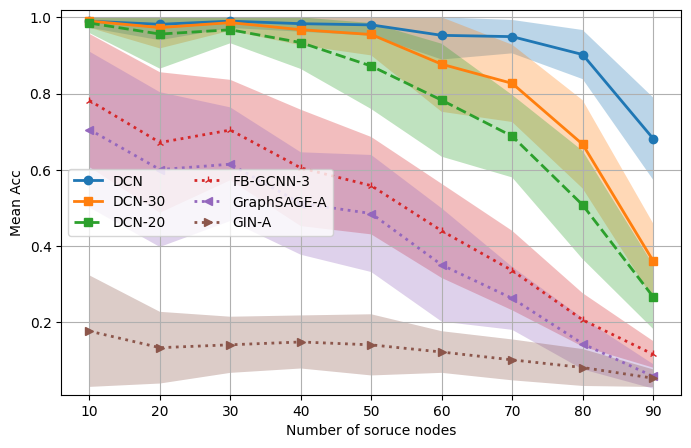

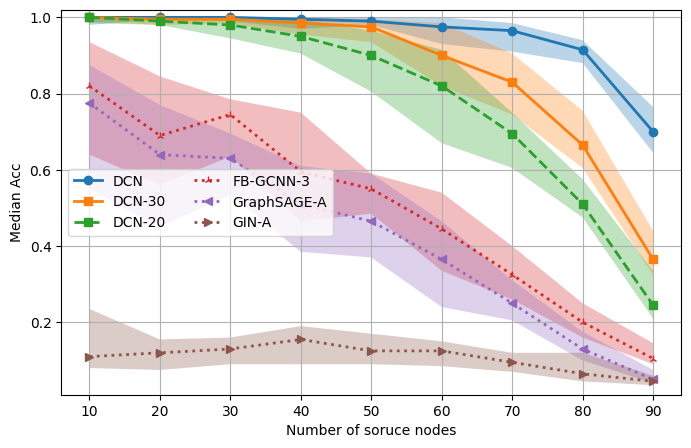

In [15]:
mean_acc = acc.mean(axis=0)
med_acc = np.median(acc, axis=0)
std_acc = acc.std(axis=0)
prctile25_acc = np.percentile(acc, 25, axis=0)
prctile75_acc = np.percentile(acc, 75, axis=0)

if SAVE:
    # Save np files
    file_name = PATH + f'src_nodes/src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Max_sources)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc)
    file_name_data = f'{file_name}-std_up_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc + std_acc)
    file_name_data = f'{file_name}-std_down_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc - std_acc)
    # file_name_data = f'{file_name}-mean_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc)
    # file_name_data = f'{file_name}-std_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, Max_sources, std_acc)
    file_name_data = f'{file_name}-med_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, med_acc)
    file_name_data = f'{file_name}-prct75_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, prctile75_acc)
    file_name_data = f'{file_name}-prct25_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, prctile25_acc)

legend = [exp['leg'] for exp in Exps]
skip = [3, 5, 6, 9] #[4, 5, 8]
utils.plot_results(mean_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False, std=std_acc,
                   ylabel='Mean Acc', n_cols=2, ylim_top=1.02, skip_idx=skip)

utils.plot_results(med_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False, n_cols=2, 
                   ylabel='Median Acc', prctile_up=prctile75_acc, prctile_low=prctile25_acc,
                   ylim_top=1.02, skip_idx=skip)


In [4]:
# file_name = PATH + 'src_nodes/src_nodes_inf-random.npz'
# acc, times, Exps, Max_sources = utils.load_data(file_name, src_id=True)

## Influence of the graph

### Varying the density of the graph

In [26]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, p in enumerate(P_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['p'] = p
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(p))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [30]:
P_values = np.array([.1, .2, .3, .4, .5, .6, .7])

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20, 'transp': True}, 'leg': 'DCN-20',
     'fmt': 'P--'}, 
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10',
    #  'fmt': 's-.'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': True}, 'leg': 'FB-GCNN-2', 'fmt': '2-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4', 'fmt': '2-.'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 5, 'transp': True}, 'leg': 'FB-GCNN-5', 'fmt': '2-.'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 6, 'transp': True}, 'leg': 'FB-GCNN-6', 'fmt': '2:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 7, 'transp': True}, 'leg': 'FB-GCNN-7', 'fmt': '2:'},
    
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A',  'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A',
      'fmt': '>:'},
    ]

acc, times = influence_graph_density(data_p, default_arch_p, default_mod_p, P_values, Exps)


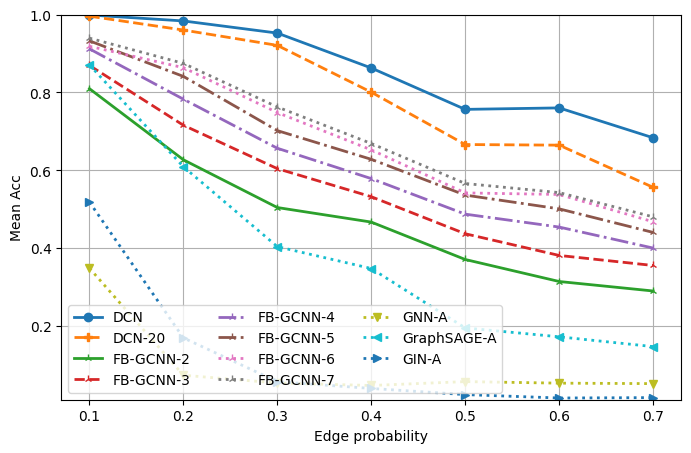

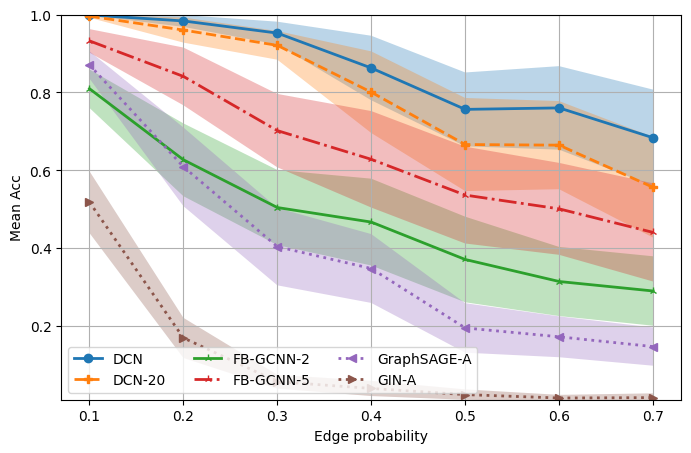

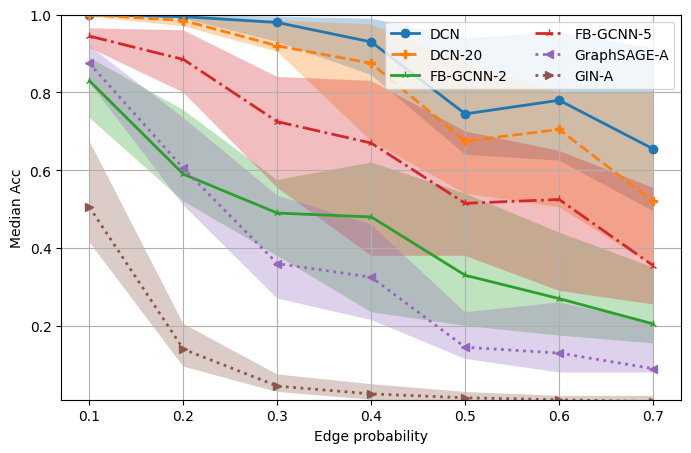

In [52]:
mean_acc = acc.mean(axis=0)
std_acc = acc.std(axis=0)
med_acc = np.median(acc, axis=0)
prctile25_acc = np.percentile(acc, 25, axis=0)
prctile75_acc = np.percentile(acc, 75, axis=0)

if SAVE:
    # Save numpy data
    file_name = PATH + f'density/density_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc)
    # file_name_data = f'{file_name}-std_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, P_values, std_acc)
    file_name_data = f'{file_name}-std_up_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc + std_acc)
    file_name_data = f'{file_name}-std_down_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc - std_acc)
    file_name_data = f'{file_name}-med_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, med_acc)
    file_name_data = f'{file_name}-prct75_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile75_acc)
    file_name_data = f'{file_name}-prct25_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile25_acc)

legend = [exp['leg'] for exp in Exps]

# Plot mean + std
skip = []  # [2, 3, 4, 6]
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip,
                   ylabel='Mean Acc', n_cols=3, std=None)

skip = [3, 4, 6, 7, 8]  # [2, 3, 4, 6]
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip,
                   ylabel='Mean Acc', n_cols=3, std=std_acc)

# skip = []  # [1, 3, 5, 7, 10]
utils.plot_results(med_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip, n_cols=2,
                   ylabel='Median Acc', prctile_up=prctile75_acc, prctile_low=prctile25_acc)

SAVED FILE: results/src_id/density/density_inf-random
SAVED as: results/src_id/density/density_inf-random-mean_acc.csv
SAVED as: results/src_id/density/density_inf-random-std_up_acc.csv
SAVED as: results/src_id/density/density_inf-random-std_down_acc.csv
SAVED as: results/src_id/density/density_inf-random-med_acc.csv
SAVED as: results/src_id/density/density_inf-random-prct75_acc.csv
SAVED as: results/src_id/density/density_inf-random-prct25_acc.csv


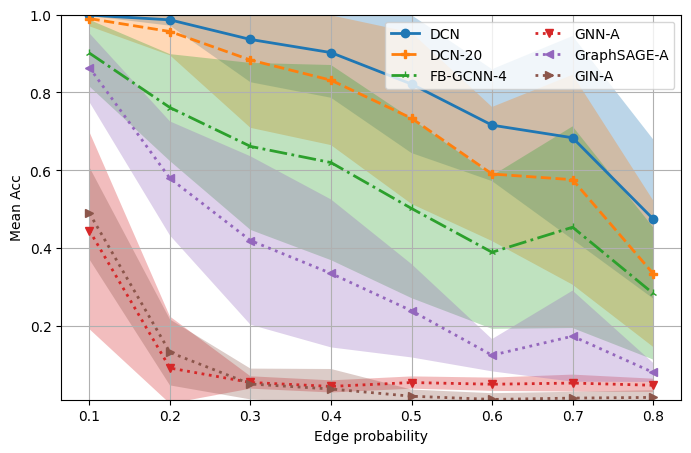

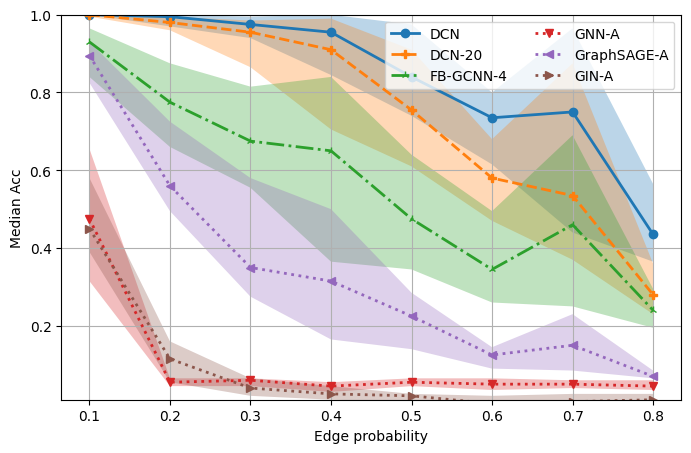

In [ ]:
mean_acc = acc.mean(axis=0)
std_acc = acc.std(axis=0)
med_acc = np.median(acc, axis=0)
prctile25_acc = np.percentile(acc, 25, axis=0)
prctile75_acc = np.percentile(acc, 75, axis=0)

if SAVE:
    # Save numpy data
    file_name = PATH + f'density/density_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc)
    # file_name_data = f'{file_name}-std_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, P_values, std_acc)
    file_name_data = f'{file_name}-std_up_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc + std_acc)
    file_name_data = f'{file_name}-std_down_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc - std_acc)
    file_name_data = f'{file_name}-med_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, med_acc)
    file_name_data = f'{file_name}-prct75_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile75_acc)
    file_name_data = f'{file_name}-prct25_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile25_acc)

legend = [exp['leg'] for exp in Exps]

# Plot mean + std
skip = [2, 3, 4, 6]
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip,
                   ylabel='Mean Acc', n_cols=2, std=std_acc)

# skip = []  # [1, 3, 5, 7, 10]
utils.plot_results(med_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip, n_cols=2,
                   ylabel='Median Acc', prctile_up=prctile75_acc, prctile_low=prctile25_acc)

In [16]:
# file_name = PATH + 'density/density_inf-random.npz'
# acc, times, Exps, P_values = utils.load_data(file_name, src_id=True)

### Varying the size of the graph

In [ ]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, n_nodes in enumerate(N_nodes):
            data_params_aux = dict(d_dat_p)
            data_params_aux['N'] = n_nodes
            # Always use second half of nodes to generate data
            data_params_aux['max_GSO'] = n_nodes
            data_params_aux['min_GSO'] = int(n_nodes/2)
            available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
            data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes) 
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [ ]:
N_nodes = [25, 50, 100, 200, 400]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25, 'transp': True}, 'leg': 'DCN-25-T',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15, 'transp': True}, 'leg': 'DCN-15-T',
     'fmt': 's-'}, 
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_graph_size(data_p, default_arch_p, default_mod_p, N_nodes, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, N_nodes, Exps, 'Number of nodes', logy=False, n_cols=2,
                   ylabel='Mean Acc')
utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', logy=True, ylabel='Mean time (secs)',
                   ylim_bottom=1, ylim_top=100, n_cols=2)


In [ ]:
# file_name = PATH + 'n_nodes_inf-random.npz'
# acc, times, Exps, N_nodes = utils.load_data(file_name, src_id=True)

## Noise influence

In [ ]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, noise in enumerate(Noise_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_p_y'] = noise
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [ ]:
Noise_values = np.arange(0, .41, .05)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25, 'transp': True}, 'leg': 'DCN-25-T',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15, 'transp': True}, 'leg': 'DCN-15-T',
     'fmt': 's-'}, 
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_noise(data_p, default_arch_p, default_mod_p, Noise_values, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'noise_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, Noise_values, Exps, 'Normalized noise power', ylabel='Mean Acc',
                   logy=False, n_cols=2)
utils.plot_results(mean_time, Noise_values, Exps, 'Normalized noise power', logy=False, ylabel='Mean time (secs)',
                   ylim_bottom=None, ylim_top=None, n_cols=2)


In [ ]:
# file_name = PATH + 'noise_inf-random.npz'
# acc, times, Exps, Noise_values = utils.load_data(file_name, src_id=True)